# Feature Importance Analysis: Distinguishing Between Upskilling and Reskilling Programs
This notebook analyzes features that distinguish between upskilling and reskilling programs using two approaches:

1. Using all variables (including outcomes)
2. Using only program characteristics (excluding outcomes)

In [1]:
# Required Libraries
import pandas as pd
import numpy as np
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Import variable definitions
from variable_definitions import (
    label_mapping, program_variables, outcomes_to_exclude, add_unique_keys
)

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualization settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

c:\Users\user\Desktop\HBS-Survey\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading and Preparation
We'll first load the data and define our mapping dictionaries for feature labels.

In [2]:
# Load data
data = pd.read_stata("../Data/V1_qualflags_analysis2_ML.dta")
df, meta = pyreadstat.read_dta("../Data/V1_qualflags_analysis2_ML.dta")
variable_labels = dict(zip(data.columns, meta.column_labels))

# Define label mapping for better readability
label_mapping = add_unique_keys(label_mapping, variable_labels)

# Display program distribution
print("Program Type Distribution:")
print("-" * 50)
program_dist = data['program'].value_counts()
print(program_dist)
print(f"\nProgram Balance: {(program_dist['Reskilling']/program_dist['Upskilling']):.2f}:1")

Program Type Distribution:
--------------------------------------------------
program
Reskilling    673
Upskilling    464
General        72
Name: count, dtype: int64

Program Balance: 1.45:1


## Analysis 1: Complete Dataset (Including Outcomes)
This first analysis uses all variables, including outcome variables, to identify the key differentiating features between upskilling and reskilling programs.

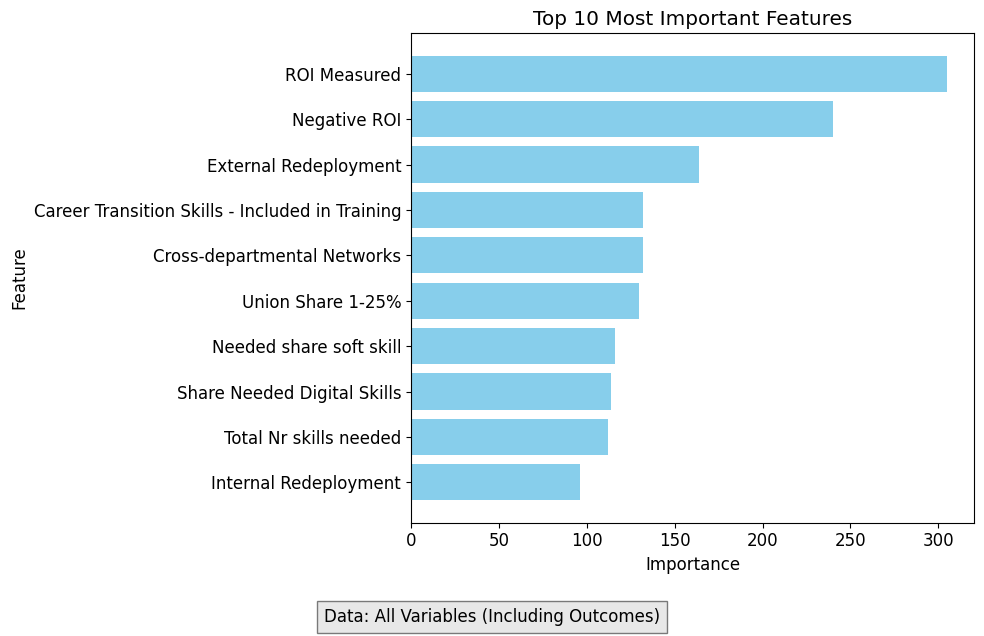

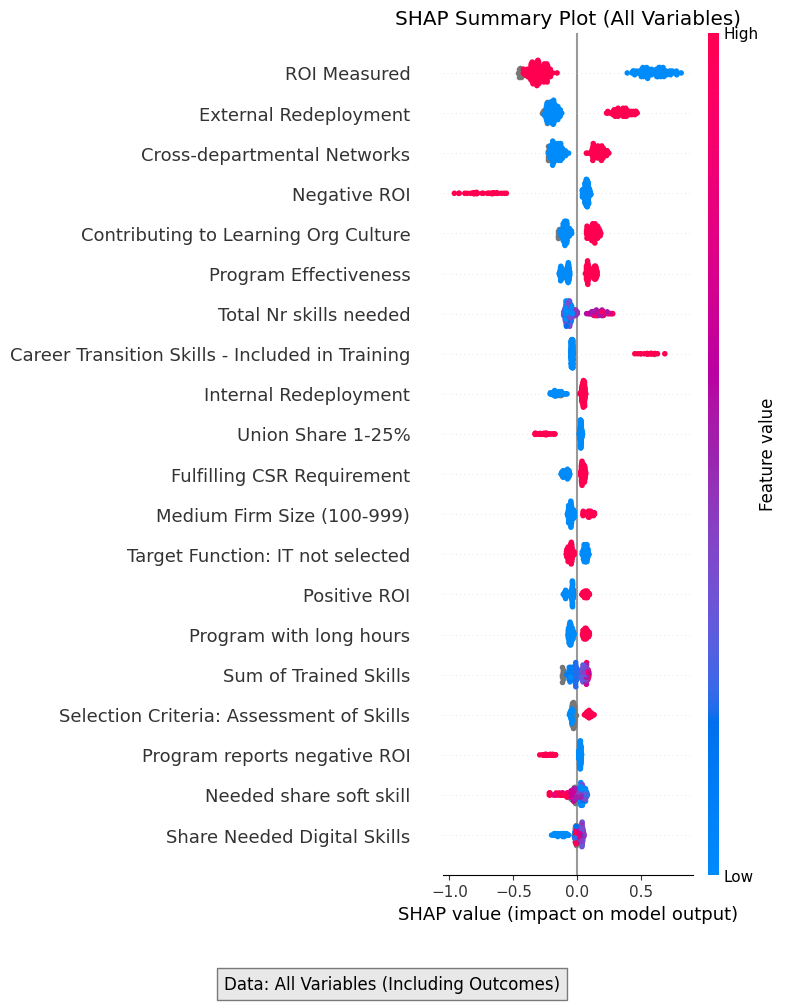

In [3]:
def preprocess_data(data, analyze=False):
    """
    Preprocess data for model training
    """
    # Create copy to avoid modifying original data
    df = data.copy()
    
    # Handle missing values
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    
    # For numeric columns, fill with median
    for col in numeric_columns:
        df[col] = df[col].fillna(df[col].median())
    
    # For categorical columns, fill with mode
    for col in categorical_columns:
        df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else None)
    
    # Create dummy variables for categorical columns
    df_dummies = pd.get_dummies(df)
    
    # Clean column names
    df_dummies.columns = [col.replace('>', 'greater').replace('<', 'less').replace(',', '_').replace(' ', '_') 
                          for col in df_dummies.columns]
    
    # Convert boolean to integer
    df_dummies = df_dummies.replace({True: 1, False: 0})
    
    return df_dummies

# Create target variable - Reskilling = 1, Upskilling = 0
def create_target(data):
    """Create binary target variable from program type"""
    return np.where(data['program'] == 'Reskilling', 1, 0)

# Preprocess data
preprocessed_data = preprocess_data(data)

# Create target variable
target = create_target(data)

# Remove target columns from feature set
X = preprocessed_data.drop(['program_Reskilling', 'program_Upskilling', 'program_General'], axis=1, errors='ignore')
y = target

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train XGBoost model
model = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.005,
    n_estimators=1000,
    min_child_weight=7,
    gamma=0.15,
    subsample=0.65,
    colsample_bytree=0.7,
    lambda_=8,
    alpha=2,
    scale_pos_weight=1.45,
    random_state=42,
    eval_metric=['auc', 'logloss']
)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Get feature importances
feature_importance = model.get_booster().get_score(importance_type='weight')
feature_importance = {label_mapping.get(k, k): v for k, v in feature_importance.items()}
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Get top 10 features
top_10_features = sorted_features[:10]
features, importances = zip(*top_10_features)

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(list(reversed(features)), list(reversed(importances)), color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.figtext(0.5, -0.05, "Data: All Variables (Including Outcomes)", 
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.tight_layout()
plt.savefig('top10_features_all_data.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate SHAP values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_val)

# SHAP Summary Plot for all features
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values,
    X_val,
    feature_names=[label_mapping.get(col, col) for col in X_val.columns],
    show=False
)
plt.title("SHAP Summary Plot (All Variables)")
plt.figtext(0.5, -0.05, "Data: All Variables (Including Outcomes)", 
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.tight_layout()
plt.savefig('shap_summary_all_data.png', dpi=300, bbox_inches='tight')
plt.show()

## Analysis 2: Program Characteristics Only (Excluding Outcomes)
This second analysis focuses only on program characteristics, excluding outcome variables, to identify key differentiating features.

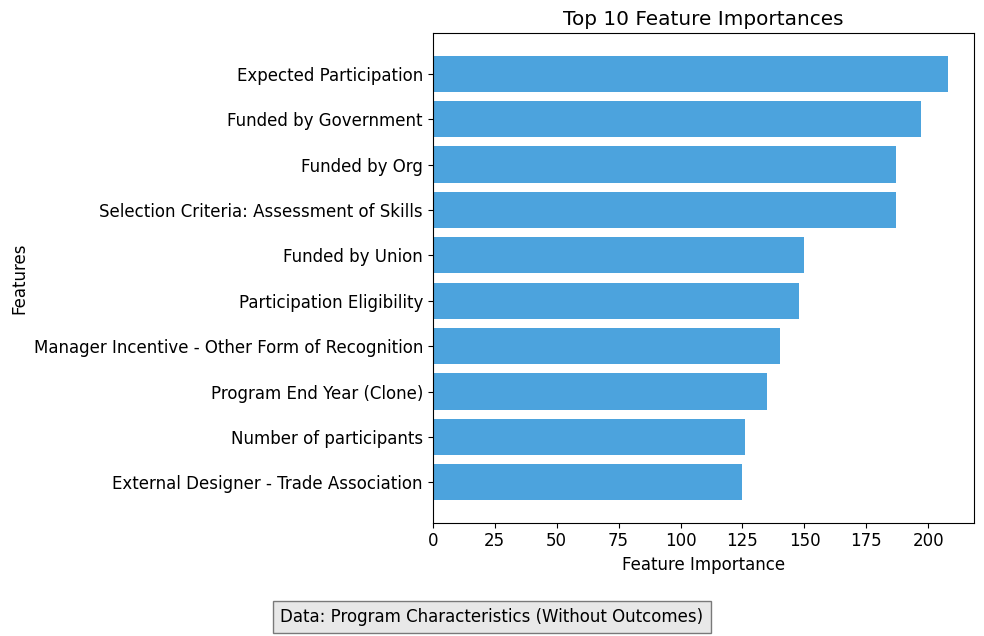

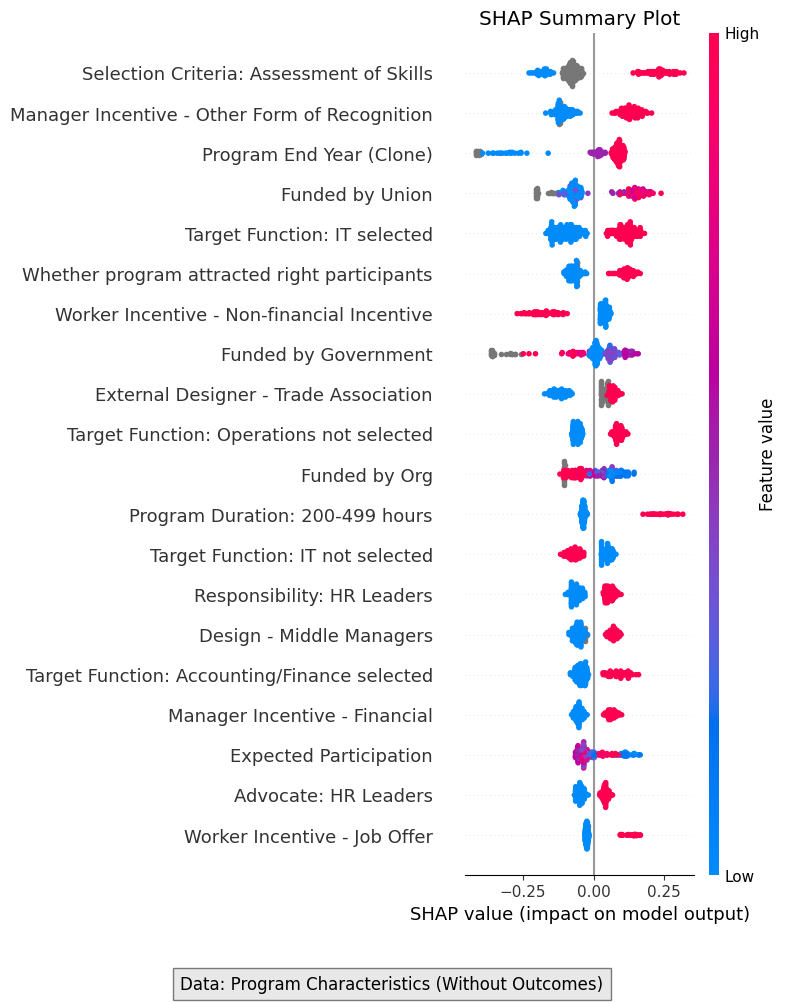

In [4]:
# Create dummy variables
data_dummies = pd.get_dummies(data)

# Clean column names
data_dummies.columns = [col.replace('>', 'greater').replace('<', 'less').replace(',', '_').replace(' ', '_') 
                        for col in data_dummies.columns]
data_dummies = data_dummies.replace({True: 1, False: 0})

# Create target variable
outcomes = [1 if out == 'Reskilling' else 0 for out in data['program']]

# Filter dataset to include only program variables and exclude outcome variables
program_columns = [col for col in data_dummies.columns if any(col.startswith(p) for p in program_variables)]
program_columns = [col for col in program_columns if col not in outcomes_to_exclude]
program_data = data_dummies[program_columns]

# Split data
X_train_prog, X_val_prog, y_train_prog, y_val_prog = train_test_split(
    program_data, outcomes, test_size=0.2, random_state=42, stratify=outcomes
)

# Train XGBoost model on program characteristics only
prog_model = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.005,
    n_estimators=1000,
    min_child_weight=7,
    gamma=0.15,
    subsample=0.65,
    colsample_bytree=0.7,
    lambda_=8,
    alpha=2,
    scale_pos_weight=1.45,
    random_state=42,
    eval_metric=['auc', 'logloss']
)

prog_model.fit(X_train_prog, y_train_prog, eval_set=[(X_val_prog, y_val_prog)], verbose=False)

# Get feature importances
prog_feature_importance = prog_model.get_booster().get_score(importance_type='weight')
prog_feature_importance = {label_mapping.get(k, k): v for k, v in prog_feature_importance.items()}
prog_sorted_features = sorted(prog_feature_importance.items(), key=lambda x: x[1], reverse=True)

# Get top 10 features
prog_top_10_features = prog_sorted_features[:10]
prog_features, prog_importances = zip(*prog_top_10_features)

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(list(reversed(prog_features)), list(reversed(prog_importances)), color='#4CA3DD')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances')
plt.figtext(0.5, -0.05, "Data: Program Characteristics (Without Outcomes)", 
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.tight_layout()
plt.savefig('top10_features_program_chars.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate SHAP values for program characteristics
prog_explainer = shap.Explainer(prog_model, X_train_prog)
prog_shap_values = prog_explainer(X_val_prog)

# SHAP Summary Plot for program characteristics
plt.figure(figsize=(12, 8))
shap.summary_plot(
    prog_shap_values,
    X_val_prog,
    feature_names=[label_mapping.get(col, col) for col in X_val_prog.columns],
    show=False
)
plt.title("SHAP Summary Plot")
plt.figtext(0.5, -0.05, "Data: Program Characteristics (Without Outcomes)", 
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.tight_layout()
plt.savefig('shap_summary_program_chars.png', dpi=300, bbox_inches='tight')
plt.show()